# Training quantum process transformation with PQC

**Table of Contents**

- [Introduction](#Introduction)
- [Background](#Background)
- [Construct from Scratch](#Construct-a-PQC-to-train-process-transformation-from-scratch)
  - [Construct the quantum circuit](#Construct-the-quantum-circuit)
  - [Loss function](#Loss-function)
  - [Training the PQC](#Training-the-circuit)
- [PQCombNet](#Parameterized-Quantum-CombNet---a-ml-tool-for-quantum-process-transformation-training)
  - [What is quantum comb](#What-is-quantum-comb)
  - [Construct quantum comb with PQC](#Construct-quantum-comb-with-PQC)
  - [Initialize PQCombNet](#Initializing-PQCombNet)
  - [Other functional](#Other-functional)


## Introduction

Quantum processes represent the fundamental transformations that govern the evolution of quantum states, enabling the manipulation, communication, and computation of quantum information. Understanding and simulating quantum processes and their transformations is critical for advancing research in these fields.

A common approach to simulate a quantum process transformation is by using a parameterized quantum circuit (PQC), which provides a flexible framework for encoding and optimizing quantum operations. In this tutorial, we will introduce two approaches for constructing and training quantum processes using PQCs:

1. **[Constructing a PQC from Scratch ](#scratch):** This method involves building a parameterized quantum process from the ground up using our QuAIRKit's capabilities, offering fine-grained control over the circuit structure and parameters.

2. **[Simulating Process with Our QuAIR Toolkit - PQCombNet](#PQCombNet):** The PQCombNet tool, as a part of the QuAIRKit application, streamlines the initialization of quantum combs [1], enabling a more efficient and intuitive simulation of quantum process transformations.

These approaches provide versatile pathways for exploring and optimizing quantum processes, tailored to the needs of researchers and practitioners in quantum information science.

In [1]:
import time
from typing import Callable
import numpy as np
import torch


import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_device("cpu")  # alternatively, switch to "cuda:x" for GPU
qkit.set_dtype("complex128")

## Background

The time evolution of a closed quantum system is governed by a unitary operator $ U = e^{-iHt} $, where $ H $ represents the Hamiltonian of the system and $ t $ denotes time. The inverse of this transformation is given by $ U^{-1} = e^{iHt} $. This reversible nature of quantum operations distinguishes quantum processes from classical ones, highlighting a key feature of quantum mechanics.

Reversing a quantum process by obtaining its time-reversed unitary $ U^{-1} $ is a fundamental task in quantum information science. However, deriving the inverse operation for an unknown unitary is challenging and resource-intensive. The conventional approach, known as quantum process tomography, requires a prohibitively large number of measurements to fully reconstruct the Hamiltonian $ H $ and, consequently, the entire quantum process for reversal. Alternatively, it is possible to approximate $ U^{-1} $ directly using the original unitary $ U $ without performing process tomography.

In this tutorial, two approaches to simulate the inverse of an unknown unitary by constructing parameterized quantum circuits (PQC) will be presented.


## Construct a PQC to train process transformation from scratch
The objective of our quantum circuits is to perform the inverse operation $U^{-1}$ of a given unitary $U$. In particular, this circuit should query a finite number of $U$ copies and output $f(U)\ket{\psi}$ for any input state $\ket{\psi}$, where $f(U) = U^{-1} = U^\dagger$.

In [2]:
# the target quantum process we want to simulate
f: Callable[[torch.Tensor], torch.Tensor] = dagger

In the rest of this tutorial, one will focus on the task of qubit-unitary inversion. The number of unitaries used in the circuit is named `num_slots`, and the number of ancilla qubits utilized in the circuit is denoted as `num_aux_qubits`. 

In [3]:
num_slots = 4
num_aux_qubits = 3

ancilla_systems = list(range(num_aux_qubits))
all_systems = list(range(num_aux_qubits + 1))

We also need to prepare the training set of PQC - a set of sampled unitary from the Haar measure in the 2-dimensional unitary group. 

In [4]:
num_sample = 1000

train_set = random_unitary(1, size=num_sample)

### Construct the quantum circuit

In our example, we initialize `num_slots + 1` parameterized universal qudit gates, as we want to insert the target unitary $U$ between each pair of parameterized structures. Each of these gates requires $d^2 - 1$ parameters, where $d$ is the dimension of the qudit gate. The complete circuit construction is illustrated as follows:

In [5]:
cir = Circuit(num_aux_qubits + 2)

cir.universal_qudits(all_systems)
for _ in range(num_slots):
    cir.oracle(train_set, [num_aux_qubits], latex_name=r'U_\textrm{in}') # input batch unitary
    cir.universal_qudits(all_systems)

How can we ensure that the trained circuit reliably processes any input state? A common approach is to "borrow" an additional qubit system that is initialized in one part of the Bell state. In this setup, the output of the optimal circuit will ideally be the Choi state corresponding to the target function $f$.

In [6]:
input_state = nkron(zero_state(num_aux_qubits), bell_state(2))
expect_state = bell_state(2).evolve(f(train_set), 0)

### Loss function

The loss function is chosen to be the average trace distance between the output state $\rho_{\text{out}}(U)$ and the expected state $\rho_{\text{exp}}(U)$ for all sampled unitaries $U$.
Specifically:

- $\rho_{\text{out}}(U)$ is the output state from our circuit, when $U$ is the input unitary.
- $\rho_{\text{exp}}(U)$ is the expected output state, expected to be $\frac{1}{2}\sum_{i, j=0}^1 f(U) \ket{i}\bra{j} f(U)^\dagger \otimes \ket{i}\bra{j}$.

The trace distance is defined as:
$$
D(\rho, \sigma) = \frac{1}{2}\operatorname{tr}\left|\rho - \sigma\right|,
\tag{1}
$$

where $|A|$ represents the positive semidefinite square root of $A^\dagger A$. Then the loss function is mathematically represented as
$$
\mathcal{L} = \frac{1}{\text{\# of } U} \sum_{U} D(\rho_{\text{out}}(U), \rho_{\text{exp}}(U)).
\tag{2}
$$


In [7]:
def loss_func(circuit: Circuit) -> torch.Tensor:
    r"""Compute the loss function according to Equation (2)
    
    Args:
        circuit: the quantum circuit to be trained
        
    Returns:
        the average trace distance between the output state and the expect state
    
    """
    output_state = circuit(input_state).trace(ancilla_systems)
    return trace_distance(output_state, expect_state).mean()

One also needs to setup a fidelity function to test the generality of our trained circuit. To do this, one could use another batch of random unitaries to construct a new batched circuit. Such circuit is passed through a random input state, to see the state fidelity between the output states of the trained circuit with the expected output states. Note that for test case, there is no need to add an extra line.

In [8]:
test_set = random_unitary(1, size=num_sample)
test_state = random_state(1)
test_input_state = nkron(zero_state(num_aux_qubits), test_state)
test_expect_state = test_state.evolve(f(test_set), 0)

def fidelity_func(circuit: Circuit) -> torch.Tensor:
    r"""Compute the fidelity between the output state and the expect state
    
    Args:
        circuit: the quantum circuit to be trained
        
    Returns:
        the average fidelity between the output state and the expect state
    
    """
    
    test_cir = Circuit(num_aux_qubits + 1)
    test_cir.universal_qudits(all_systems)
    for _ in range(num_slots):
        test_cir.oracle(test_set, [num_aux_qubits])
        test_cir.universal_qudits(all_systems)
    test_cir.update_param(circuit.param)
    
    output_state = test_cir(test_input_state).trace(ancilla_systems)
    return state_fidelity(output_state, test_expect_state).mean()

### Train the circuit


After setting up learning rate and total number of iterations, we are now ready to train the circuit with our predefined loss function $\mathcal{L}$ to simulate the process transformation $f(U) = U^{-1}$.


In [9]:
lr = 0.05
num_iter = 2000
opt = torch.optim.Adam(cir.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)

In [10]:
time_list = []
for itr in range(num_iter):
    start_time = time.time()
    opt.zero_grad()

    loss = loss_func(cir) # compute loss

    loss.backward()
    opt.step()
    scheduler.step(loss) # activate scheduler

    time_list.append(time.time() - start_time)

    if itr % (num_iter // 10) == 0 or itr == num_iter - 1:
        fidelity = fidelity_func(cir).item()
        print(f"iter: {str(itr).zfill(len(str(num_iter)))}, " +
              f"loss: {loss.item():.8f}, fidelity: {fidelity:.8f}, " +
              f"lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s")
        time_list = []

iter: 0000, loss: 0.78368684, fidelity: 0.74825881, lr: 5.00E-02, avg_time: 0.0767s
iter: 0200, loss: 0.07118932, fidelity: 0.97523268, lr: 2.50E-02, avg_time: 0.0437s
iter: 0400, loss: 0.05067148, fidelity: 0.98335111, lr: 1.25E-02, avg_time: 0.0434s
iter: 0600, loss: 0.03931480, fidelity: 0.98649605, lr: 6.25E-03, avg_time: 0.0408s
iter: 0800, loss: 0.03309163, fidelity: 0.98880576, lr: 3.13E-03, avg_time: 0.0374s
iter: 1000, loss: 0.02946343, fidelity: 0.99014120, lr: 3.13E-03, avg_time: 0.0444s
iter: 1200, loss: 0.02581329, fidelity: 0.99145987, lr: 3.13E-03, avg_time: 0.0386s
iter: 1400, loss: 0.02415567, fidelity: 0.99204658, lr: 7.81E-04, avg_time: 0.0377s
iter: 1600, loss: 0.02323923, fidelity: 0.99237217, lr: 7.81E-04, avg_time: 0.0383s
iter: 1800, loss: 0.02224896, fidelity: 0.99272043, lr: 7.81E-04, avg_time: 0.0383s
iter: 1999, loss: 0.02119630, fidelity: 0.99308737, lr: 7.81E-04, avg_time: 0.0403s


As shown by above training result, one can obtain a trained circuit that can effectively simulate the inverse of a given unitary $U$, with test fidelity above 99%.

## Parameterized Quantum CombNet - a ML tool for quantum process transformation training

Apparently above construction is far more complicated for beginners in quantum information science. To simplify the code work, we have developed a class named `PQCombNet` to streamline above process, and bring more functionalities to the table. To be specific, PQCombNet abstracts above idea into quantum comb, and provides a more intuitive way to train the quantum process transformation.

### What is quantum comb
A quantum comb [2] can be thought of as a series of quantum operations or gates that act sequentially or in parallel on quantum states. It is a tool to represent quantum channels, processes, or transformations that involve multiple quantum gates, typically applied to a series of quantum bits (qubits).

Here is a simple visualization of a quantum (sequential) comb:

<figure style="text-align: center;">
  <img src="./figures/Qcomb.png" alt="alt text" width="1000"/>
  <figcaption>Fig.1: The schematic representation of sequential quantum comb structure.</figcaption>
</figure>

**P** and **F** denote the input and output systems of the main register. $I_k$ and $O_k$ correspond to the input and output systems for the operation in the k-th slot. Additionally, $\mathcal{N}_\textrm{in}^{(k)}$ and $\mathcal{N}_\textrm{out}$ denote the $k$-th input operation and the final output operation highlighted by red boxes, respectively. Each tooth within the comb, corresponding to the $k$-th position, is characterized by a quantum channel $\mathcal{V}_k$. Here $\textrm{aux}_k$ denotes the ancilla system shared by $\mathcal{V}_{k-1}$ and $\mathcal{V}_k$. At the end of the circuit, the projector $\Pi$ determines the post-selection of the output auxiliary system. Usually, $\Pi$ could be selected as the identity matrix, i.e., the output auxiliary system is traced out.



### Construct quantum comb with PQC
To enhance the flexibility and adaptability of quantum combs, we utilize PQC to construct a `Parameterized Quantum Comb (PQcomb)`. For the target process transformation $f$, that take process $\mathcal{N}_\textrm{in}^{(1)}, \ldots, \mathcal{N}_\textrm{in}^{(m)}$ as inputs and $\mathcal{N}_\textrm{out}$ as an ouput, such that:
$$ 
f(\mathcal{N}_\textrm{in}^{(1)}, \ldots, \mathcal{N}_\textrm{in}^{(m)}) = \mathcal{N}_\textrm{out},
\tag{3}
$$
the PQC approach to realize such transforamtion is to replace the data processing channel by PQC parameterized by $\theta$. One choice of the loss function is the dissimilarity between the trained process $\widehat{\mathcal{N}}_\textrm{out}$ and expected process $\mathcal{N}_\textrm{out}$. Optimizing this loss function will provide us with a practical solution to achieve the desired transformation. In our previous example, such dissimilarity is measured by the trace distance (Equation (1)) between Choi states of $\widehat{\mathcal{N}}_\textrm{out}$ and $\mathcal{N}_\textrm{out}$.

###  Initializing PQCombNet <a id="initializing"></a>

First of all, import the necessary libraries for initializing the `PQCombNet` class.

In [11]:
from quairkit.application import PQCombNet

Initializing the PQCombNet, we want to achieve the process $U^{-1}$

According to the recent paper [1], the minimum resource for PQComb to implement the inverse unitary task is 4 `num_slots` and 3 `num_aux_qubits`

In [12]:
net = PQCombNet(
    target_function=dagger,  # Callable function, no default value
    num_slots=num_slots,  # Number of slots, no default value
    ancilla=num_aux_qubits,  # Number of ancilla qubits, no default value
    train_unitary_info=num_sample,  # Default: 2000 (can be an integer or torch.Tensor for training data)
    test_unitary_info=num_sample,  # Default: 10000 (can be an integer or torch.Tensor for test data)
    train_mode="process",  # Default: "process" (alternatively "pqc", which is gpu friendly)
    seed=73,  # Default: None (fix seed for reproducibility)
)

This initializes a PQCombNet instance with the specified parameters, ready for training and optimization. Now we can train our model to approximate the quantum process transformation $f(U) = U^{-1}$.

In [13]:
net.train(base_lr=lr, max_epochs=num_iter, is_save_data=False)

[pqcomb_dagger | process | 73 | 0	0.0470s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-02, Loss: 0.75544445, Fid: 0.24738995
[pqcomb_dagger | process | 73 | 100	0.0357s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-02, Loss: 0.07435474, Fid: 0.92318247
[pqcomb_dagger | process | 73 | 200	0.0372s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-02, Loss: 0.02269175, Fid: 0.97640096
[pqcomb_dagger | process | 73 | 300	0.0365s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-02, Loss: 0.00940645, Fid: 0.99023750
[pqcomb_dagger | process | 73 | 400	0.0390s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-03, Loss: 0.00524944, Fid: 0.99456681
[pqcomb_dagger | process | 73 | 500	0.0376s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-03, Loss: 0.00479748, Fid: 0.99503472
[pqcomb_dagger | process | 73 | 600	0.0368s] slot_dim: 2, slots: 4, ancilla_dim: 8, LR: 5.00e-03, Loss: 0.00434063, Fid: 0.99550775
[pqcomb_dagger | process | 73 | 700	0.0379s] slot_dim: 2, slots: 4, ancilla_di

### Other functional

We can have a view of the PQComb by the attribute `plot`.

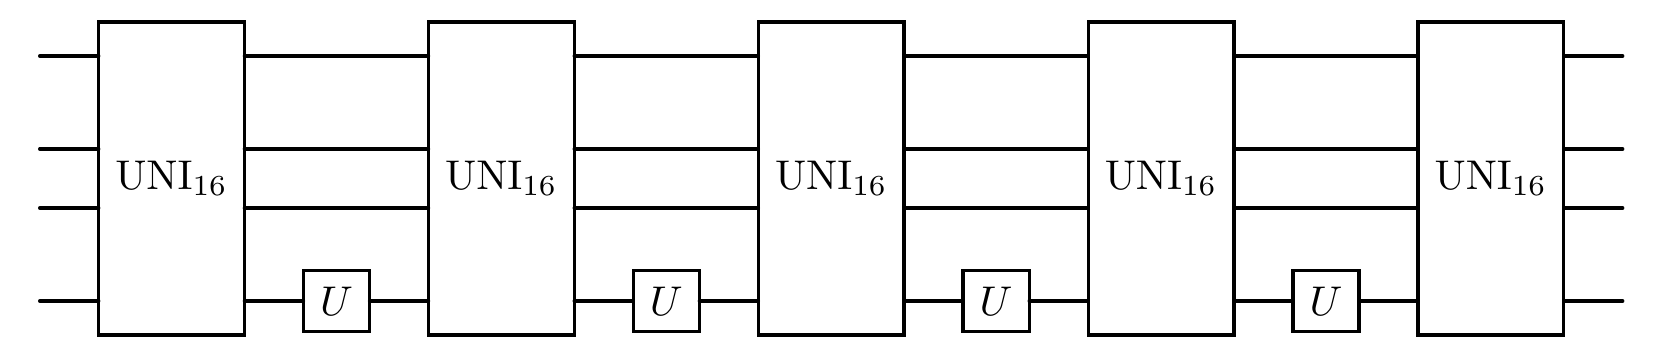

In [14]:
net.plot()

Sometimes we want to test our hypothesis that substituting a certain part of `PQCombnet` with a segment from a random parameterized circuit to a known part can enhance our understanding of quantum architecture or help in searching for an optimized one. The `PQCombnet` provides the method `update_V_circuit`, which allows users to update a specific `V` circuit at a given index within the `V_circuit_list`. The whole quantum process will then be a hybrid circuit combining known structures with the original parameterized circuit. we will show a simple example in this section about the usage of updating certain part of circuit for a **PQCombNet**


For example, we want to substitute a known circuit `new_V` and we can prepare the new_V in several ways.

In [15]:
from quairkit.operator import ParamOracle

# Number of qubits in the circuit
num_qubits_cir = num_aux_qubits + 1

# Circuit
V0 = Circuit(num_qubits_cir)
V0.real_entangled_layer(depth=2)


# ParamOracle
def V_generator(param):
    return rx(param[0]) @ u3(param[1:4]) @ h()

V1 = ParamOracle(V_generator, system_idx=list(range(num_qubits_cir)), num_acted_param=4)

# torch.Tensor as a gate working on all the systems
V2 = random_unitary(num_qubits_cir)  # Work on all the systems

# torch.Tensor as a gate working on parts of the systems
V3 = random_unitary(num_qubits_cir - 1)

Update the V circuit in place at a specified `index`.


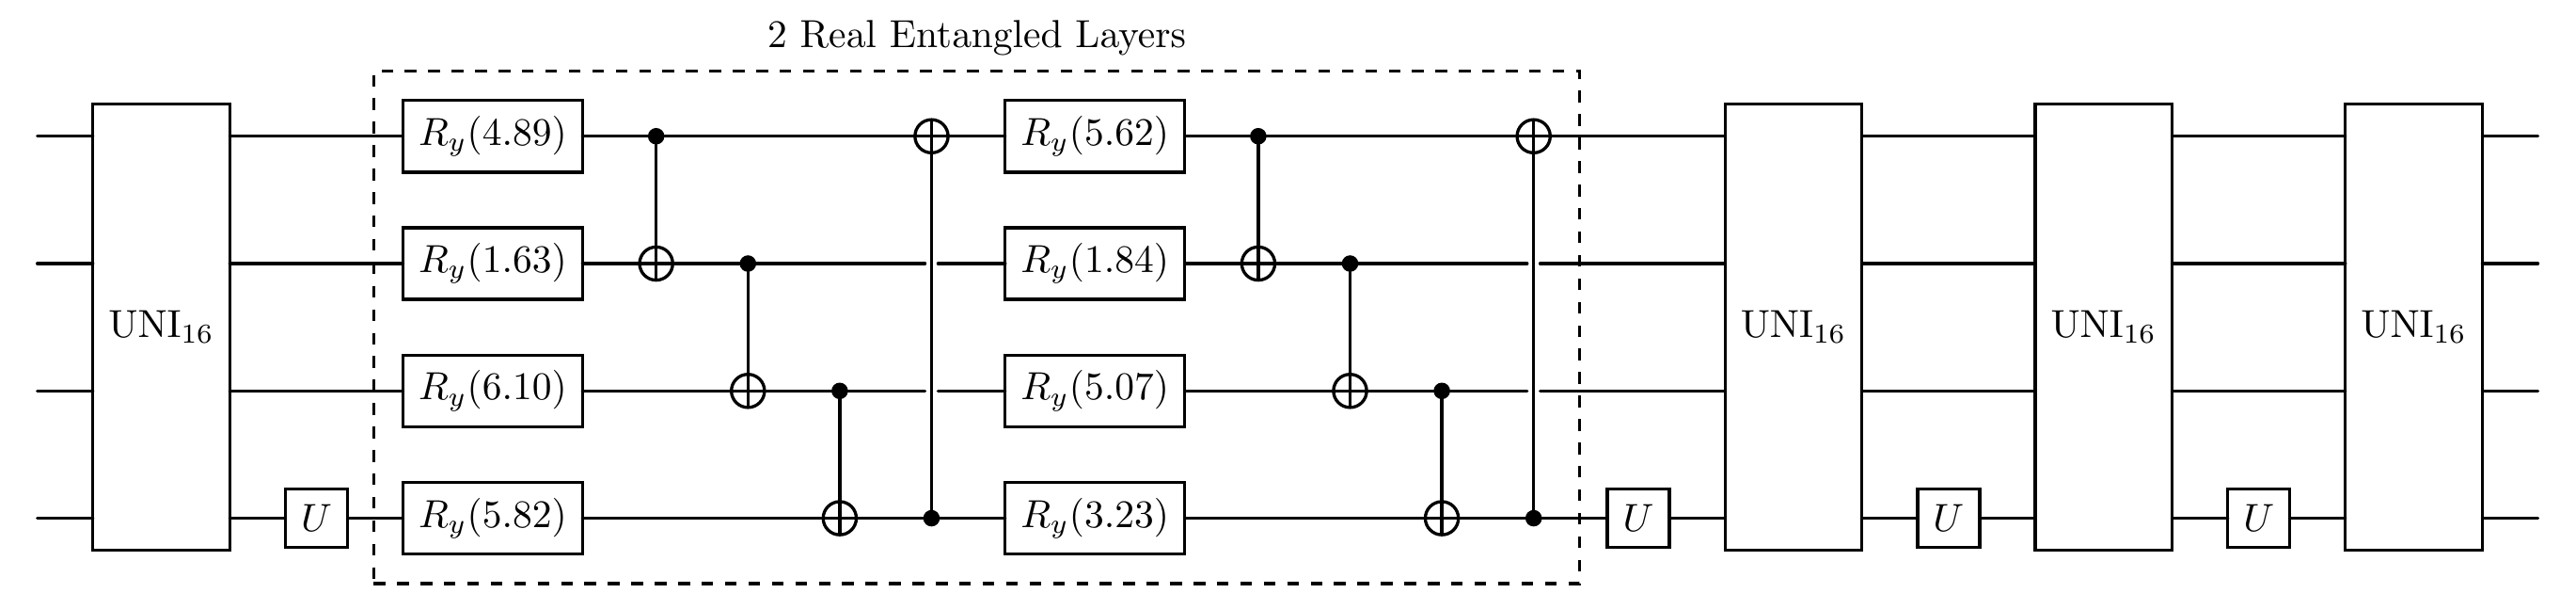

In [ ]:
# In this example, we replace the `index` 1 (the 2nd part of the PQCombNet) with our prepared structure
net.update_V_circuit(index=1, new_V=V0)  # V1,V2,V3
# we can visualize the new net after replacement
net.plot()

- **Training Data**: If `is_save_data=True`, the training data will be saved in the directory `data_directory_name/V_circuit_lists/`. Each saved file includes details like the mode used, number of qubits, and fidelity.
- **Logs**: Training logs are saved as CSV files named `{name_task}_train_log.csv` in the specified data directory.
- **Fidelity Results**: After extracting the highest fidelity, results for each `num_qubits_U` are saved as CSV files with names like `fidelity_table_num_qubits_U_{num_qubits_U}.csv`.


---

## References

[1] Mo, Yin, et al. "Parameterized quantum comb and simpler circuits for reversing unknown qubit-unitary operations." npj Quantum Information 11.1 (2025): 32.

[2] Chiribella, Giulio, G. Mauro D’Ariano, and Paolo Perinotti. "Quantum circuit architecture." Physical review letters 101.6 (2008): 060401.


In [17]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.7.0+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc


*Table: A reference of notation conventions in this tutorial.*

| Symbol                  | Description                               |
|:---------------:        |-------------------------------------------|
|$H$                      |  a Hamiltonian |
|$U$                      |  a unitary transformation |
|$f$                   | a quantum process transformation |
|$D$                   | trace distance between two quantum states|
|$\rho_{\text{out}}(U)$            | output state evolved by the train circuit with input $U$ |
|$\rho_{\text{exp}}(U)$            | expected output state, evolved by the quantum process $U^{-1}$|
|$\mathcal{L}$                   | loss function |
|$\mathcal{N}^{(k)}_\textrm{in}$ and $\mathcal{N}_\textrm{out}$          | $k$-th input operation and the final output operation|
|$I_k$ and $O_k$                 | input and output systems for the operation in the $k$-th slot|
|$\Pi$                                  | an orthogonal projector|